In [1]:
import time
from ray.tune.registry import register_env
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from pycigar.utils.logging import logger
import os
import pycigar

PATH = os.getcwd()


#file_name = '/tmp/lbnl/delete_me/half_full_40_1/run_train/run_train_1_lr=0.001_2020-06-15_02-47-57ak0kvjv5/best/policy_70'#'half_full__sim35_jun_1/full_train_1/run_train/run_train_1_lr=0.001_2020-06-02_04-24-28fbkv0xnf/best/policy'#'policy'
#file_name = '/home/toanngo/Pictures/delete_me_frame_6/half_full_40_1/run_train/run_train_0_lr=0.001_2020-06-16_19-51-18bvdh60uo/best/policy_140'
#file_name = '/home/toanngo/Pictures/delete_me_frame_6/half_full_40_0/run_train/run_train_1_lr=0.001_2020-06-16_17-51-00fejko8f_/best/policy_70'
#file_name = '/home/toanngo/Videos/sbar_eval_15_18_100_y_3/main/run_train/run_train_0_lr=0.001_2020-06-25_02-54-164assg8ul/best/policy_200'
#file_name = '/home/toanngo/Videos/sbar_eval_filter_triple/main/run_train/run_train_1_lr=0.001_2020-06-26_09-03-184puqsy4u/best/policy_240'
#file_name = '/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_0_lr=0.001_2020-06-27_20-49-39zy08f58y/best/policy_300'
#file_name = '/home/toanngo/Documents/policy_240'
#file_name = '/home/toanngo/oscillation_new_baseline_increase_action_new_slack_106_full_new_Q_80_new_bps_new_new_work_newest/main/run_train/run_train_1_lr=0.0001_2020-09-07_19-39-23045yqgw2/latest/policy_600'
file_name = '/home/toanngo/oscillation_new_baseline_increase_action_new_slack_1.06_full_new_Q_80_new_bps_new_new_work/main/run_train/run_train_0_lr=0.0001_2020-09-07_13-25-26lqtswu20/latest/policy_600'

policy = os.path.join(PATH, file_name) 
start = 100
percentage_hack = 0.2

"""
Load the scenarios configuration file. This file contains the scenario information
for the experiment.
"""
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path, benchmark=True, percentage_hack=percentage_hack)
sim_params['env_config']['sims_per_step'] = 35
sim_params['scenario_config']['custom_configs']['slack_bus_voltage'] = 1.06
sim_params['scenario_config']['custom_configs']['load_scaling_factor'] = 1.5
sim_params['scenario_config']['custom_configs']['solar_scaling_factor'] = 3
sim_params['M'] = 15
sim_params['N'] = 0.05
sim_params['P'] = 18
sim_params['Q'] = 80
sim_params['T'] = 0

pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}

create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output
tf.compat.v1.enable_eager_execution()
policy = tf.saved_model.load(policy)
infer = policy.signatures['serving_default']
done = False
obs = test_env.reset()
obs = obs.tolist()

while not done:
    act_logits = infer(
        prev_reward=tf.constant([0.], tf.float32),
        observations=tf.constant([obs], tf.float32),
        is_training=tf.constant(False),
        seq_lens=tf.constant([0], tf.int32),
        prev_action=tf.constant([0], tf.int64)
    )['action_dist_inputs'].numpy()
    act = np.argmax(act_logits)
    obs, r, done, _ = test_env.step(act)
    obs = obs.tolist()
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


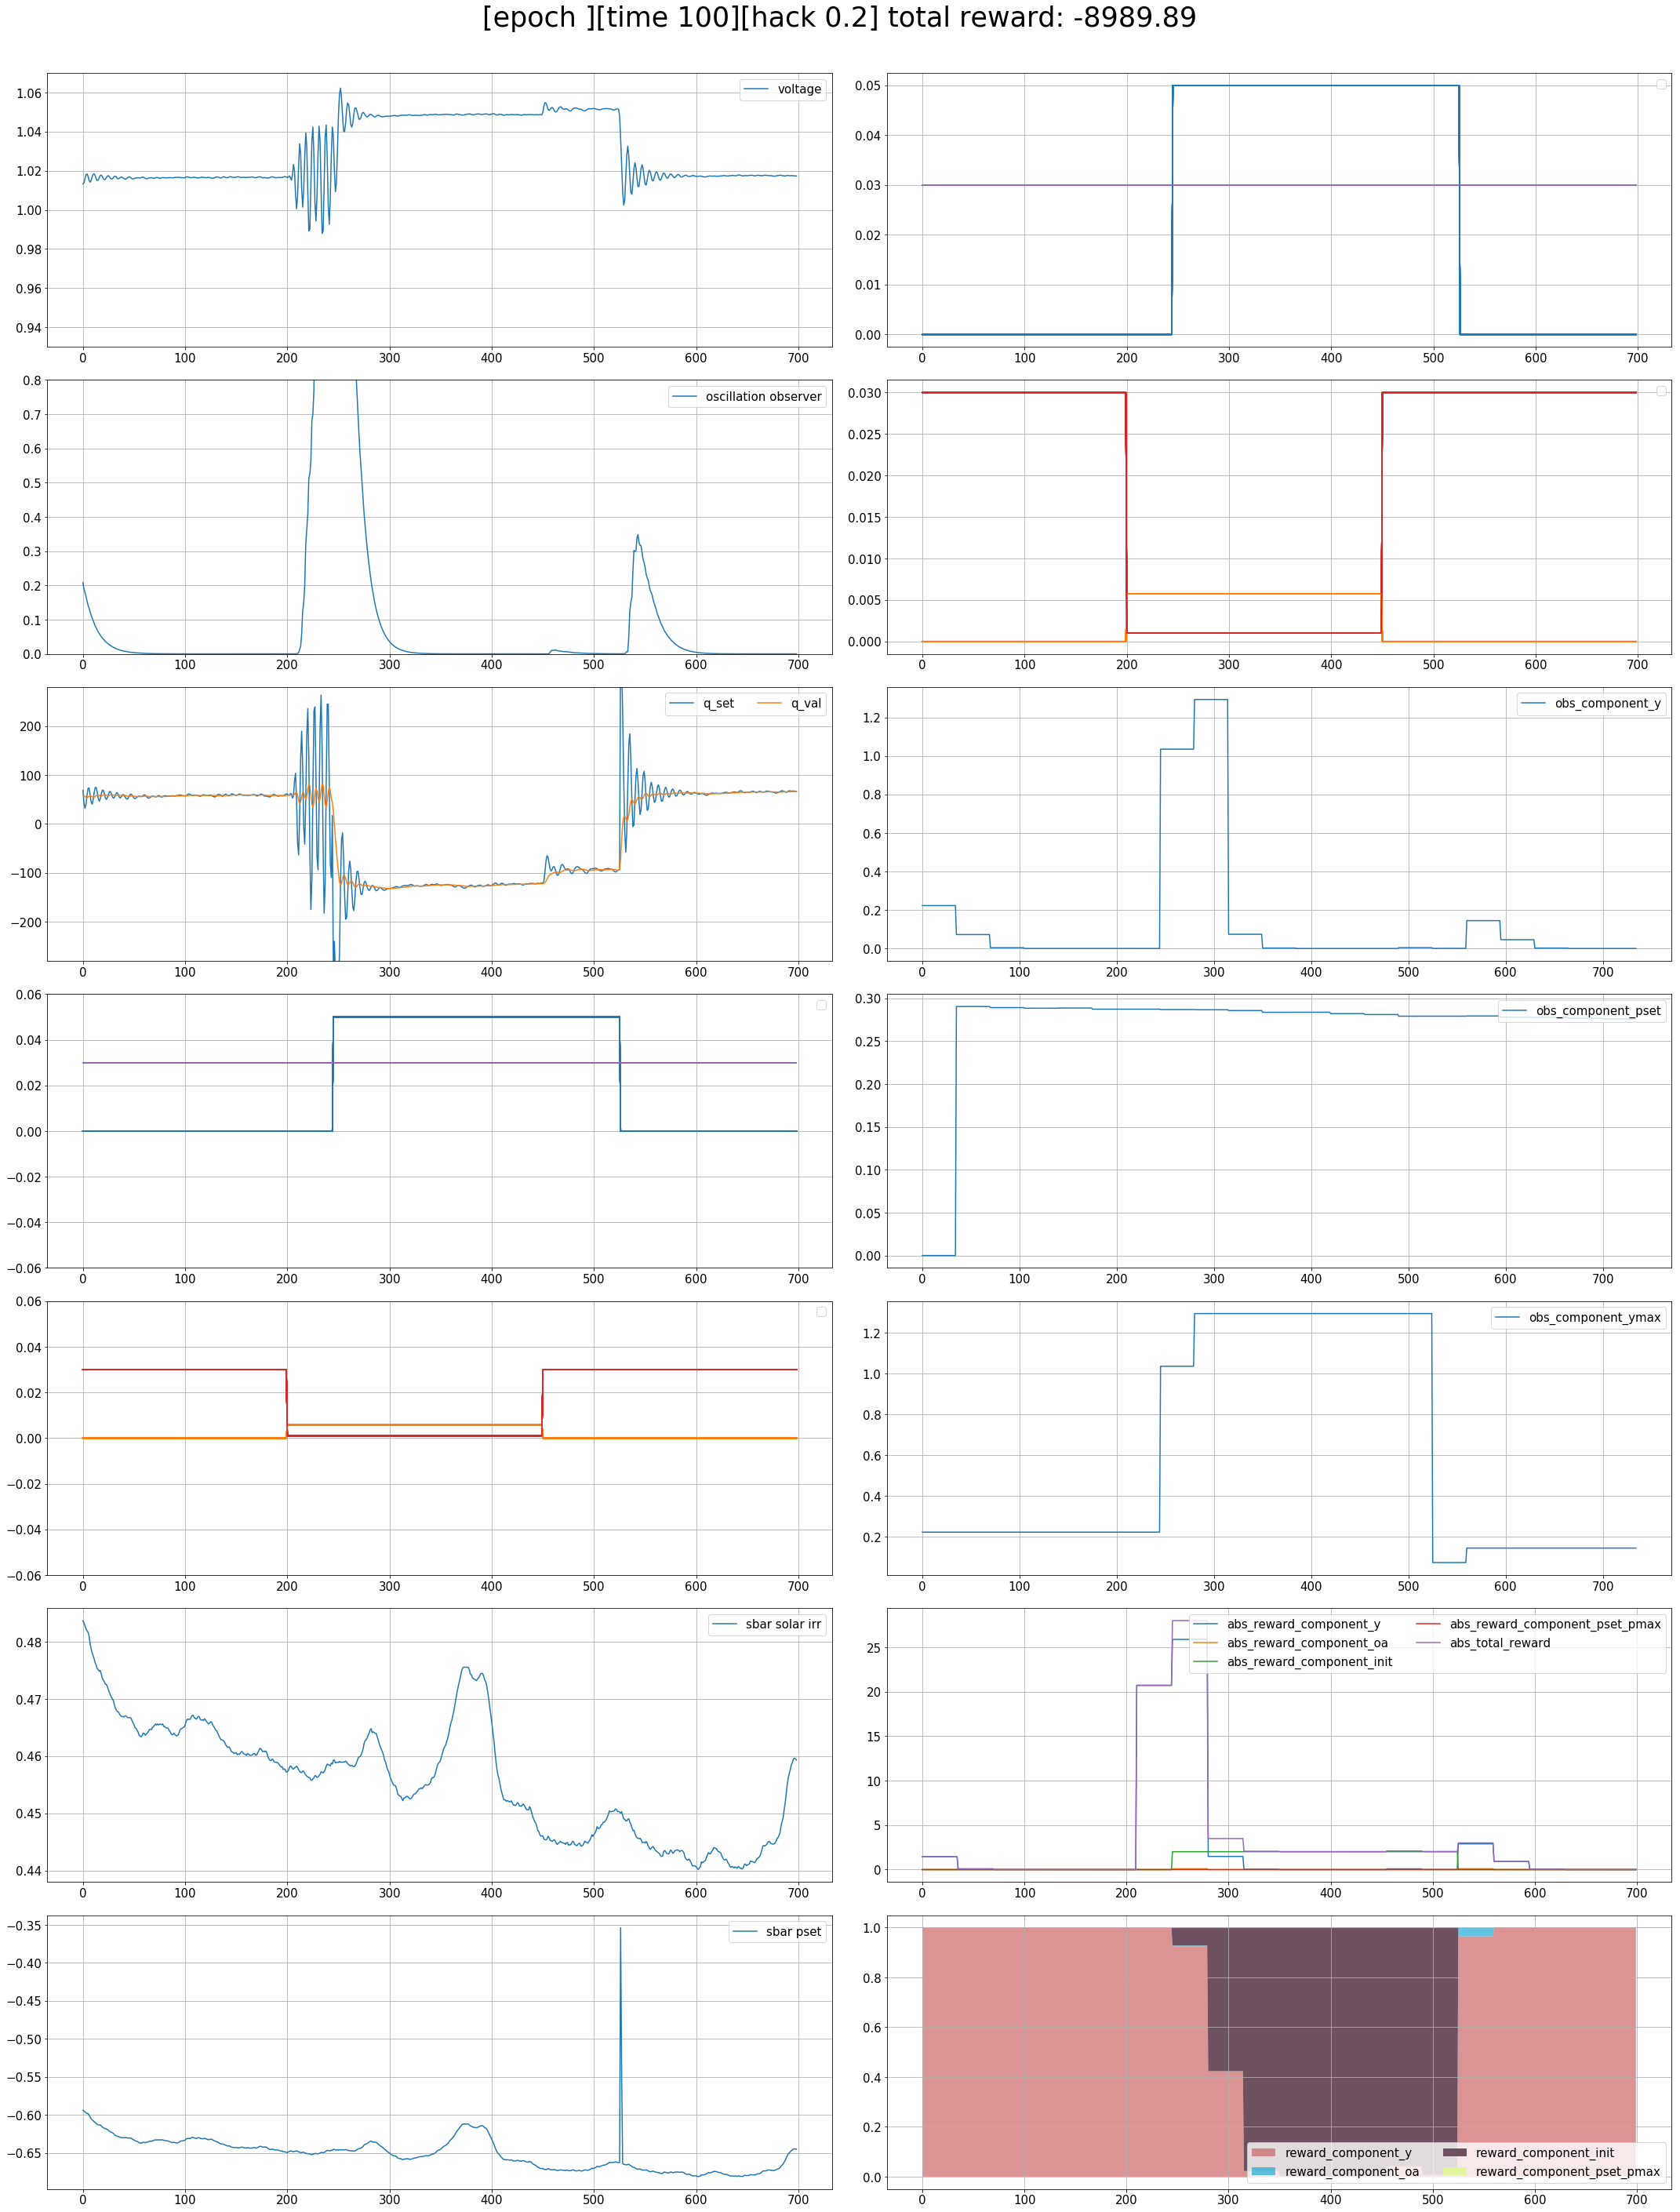

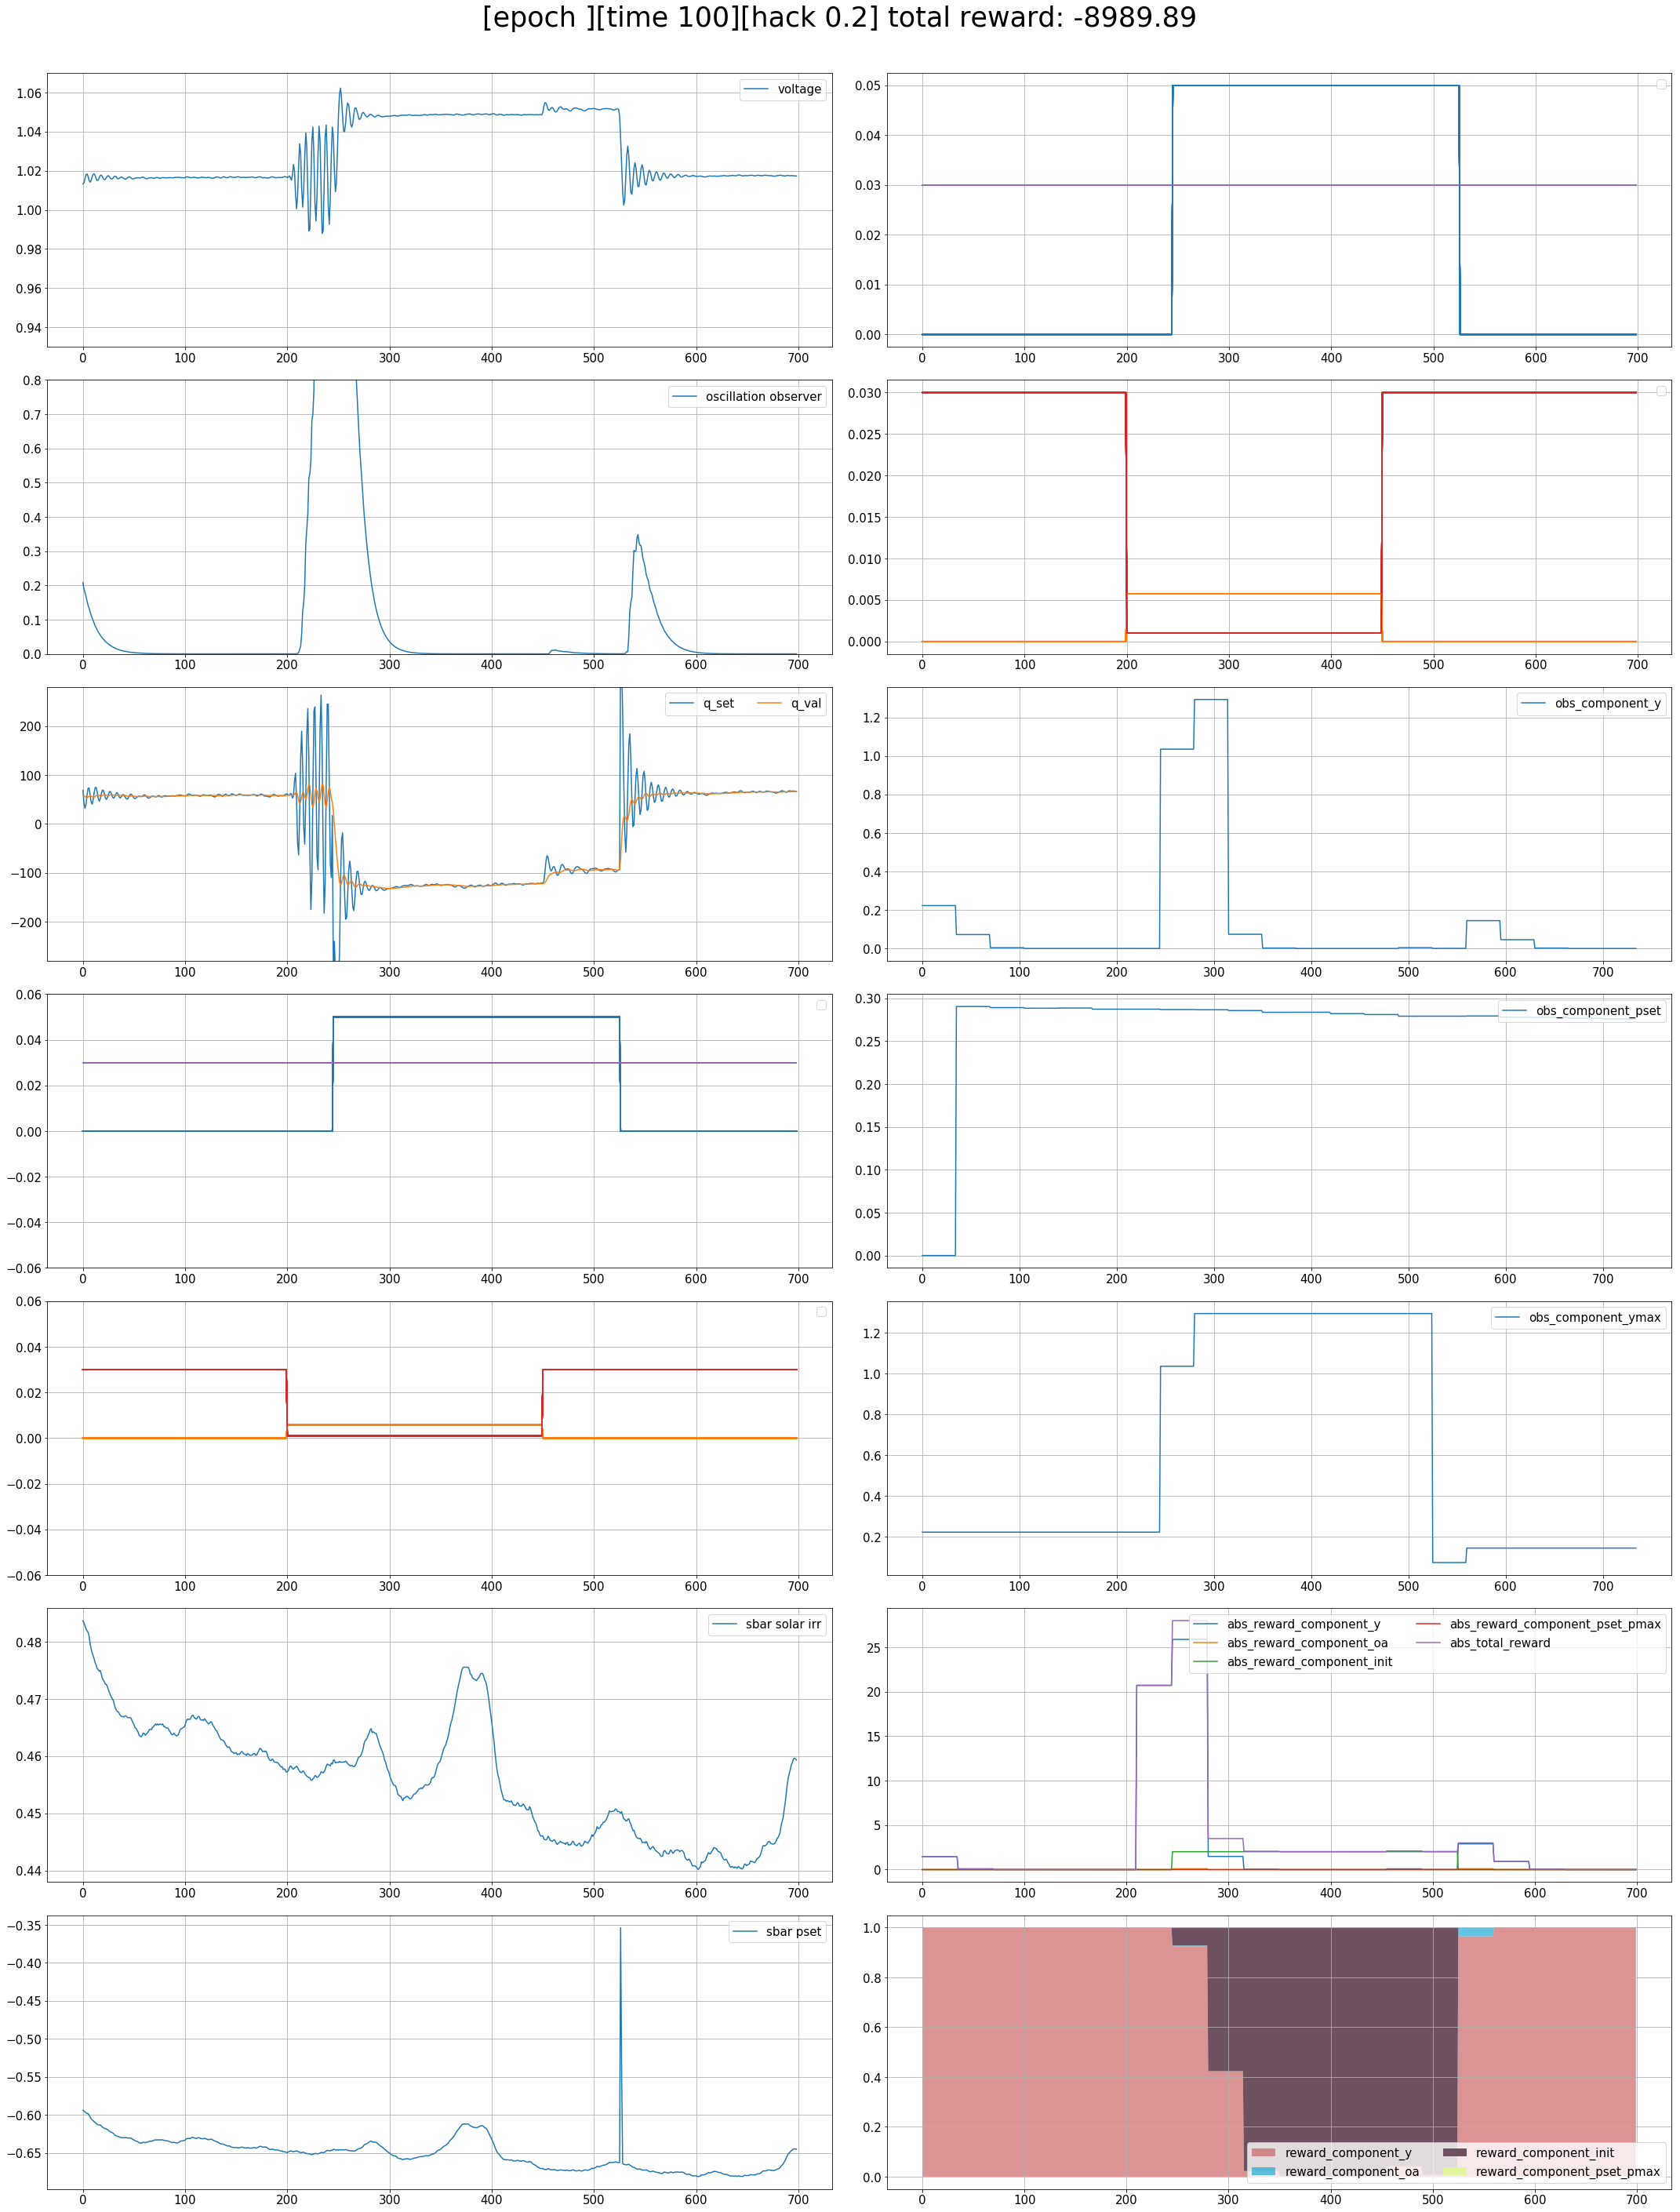

In [2]:
from pycigar.utils.output import plot_new
plot_new(log_dict, custom_metrics)

In [3]:
def get_translation_and_slope(a_val):
    points = np.array(a_val)
    slope = points[:, 1] - points[:, 0]
    og_point = points[0, 2]
    translation = points[:, 2] - og_point
    return translation, slope

In [4]:
result = {}
result['v'] = []
result['y'] = []
result['translation'] = []
result['slope'] = []
result['translation_adv'] = []
result['slope_adv'] = []
result['component_y'] = []
result['component_oa'] = []
result['component_init'] = []
result['component_pset_pmax'] = []
result['total_reward'] = []

node = 's701a'
translation, slope = get_translation_and_slope(log_dict['inverter_' + node]['control_setting'])
translation_adv, slope_adv = get_translation_and_slope(log_dict['adversary_inverter_' + node]['control_setting'])
component_y = np.array(log_dict['component_reward']['component_y'])
component_oa = np.array(log_dict['component_reward']['component_oa'])
component_init = np.array(log_dict['component_reward']['component_init'])
component_pset_pmax = np.array(log_dict['component_reward']['component_pset_pmax'])
total_reward = component_y + component_oa + component_init + component_pset_pmax

for i in range(len(log_dict[node]['voltage'])):
    result['v'].append(log_dict[node]['voltage'][i])
    result['y'].append(log_dict['inverter_' + node]['y'][i])
    result['translation'].append(translation[i])
    result['slope'].append(slope[i])
    result['translation_adv'].append(translation_adv[i])
    result['slope_adv'].append(slope_adv[i])

    result['component_y'].append(component_y[i])
    result['component_oa'].append(component_oa[i])
    result['component_init'].append(component_init[i])
    result['component_pset_pmax'].append(component_pset_pmax[i])
    result['total_reward'].append(total_reward[i])

In [5]:
import pandas as pd

df = pd.DataFrame.from_dict(result)
#df.to_csv("eval_hist_{}_{}_new_new_filter_solar_randomization_8f.csv".format(start, percentage_hack))
df.to_csv("eval_hist_{}_{}_new_new_filter_solar_randomization_8f.csv".format(100, 0.2))